<a href="https://colab.research.google.com/github/MHDoh/imdb_sentiment_nlp/blob/main/imdb_sentiment_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install the Kaggle package
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:
dataset_identifier = 'lakshmi25npathi/imdb-dataset-of-50k-movie-reviews'

!kaggle datasets download -d {dataset_identifier}
!unzip imdb-dataset-of-50k-movie-reviews.zip
data = pd.read_csv('IMDB Dataset.csv')

print(data.head())


Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})


In [ ]:
# Separate features and labels
reviews = data['review'].values
labels = data['sentiment'].values

# Split into training (70%) and temp (30%)
reviews_train, reviews_temp, labels_train, labels_temp = train_test_split(
    reviews, labels, test_size=0.30, random_state=42)

# Split temp into validation (15%) and test (15%)
reviews_val, reviews_test, labels_val, labels_test = train_test_split(
    reviews_temp, labels_temp, test_size=0.50, random_state=42)


In [ ]:
vocab_size = 10000
oov_token = '<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(reviews_train)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(reviews_train)
val_sequences = tokenizer.texts_to_sequences(reviews_val)
test_sequences = tokenizer.texts_to_sequences(reviews_test)


In [ ]:
max_length = 200
padding_type = 'post'
trunc_type = 'post'

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


In [ ]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 128, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
num_epochs = 10

history = model.fit(
    train_padded, labels_train,
    epochs=num_epochs,
    validation_data=(val_padded, labels_val),
    verbose=2
)


Epoch 1/10
1094/1094 - 42s - 38ms/step - accuracy: 0.6581 - loss: 0.6153 - val_accuracy: 0.7957 - val_loss: 0.4708
Epoch 2/10
1094/1094 - 34s - 31ms/step - accuracy: 0.8308 - loss: 0.3990 - val_accuracy: 0.8501 - val_loss: 0.3483
Epoch 3/10
1094/1094 - 41s - 37ms/step - accuracy: 0.8782 - loss: 0.3061 - val_accuracy: 0.8583 - val_loss: 0.3242
Epoch 4/10
1094/1094 - 42s - 39ms/step - accuracy: 0.9089 - loss: 0.2408 - val_accuracy: 0.8791 - val_loss: 0.2937
Epoch 5/10
1094/1094 - 41s - 37ms/step - accuracy: 0.9328 - loss: 0.1875 - val_accuracy: 0.8807 - val_loss: 0.3073
Epoch 6/10
1094/1094 - 41s - 37ms/step - accuracy: 0.9539 - loss: 0.1395 - val_accuracy: 0.8760 - val_loss: 0.3298
Epoch 7/10
1094/1094 - 41s - 37ms/step - accuracy: 0.9733 - loss: 0.0924 - val_accuracy: 0.8701 - val_loss: 0.4043
Epoch 8/10
1094/1094 - 40s - 37ms/step - accuracy: 0.9818 - loss: 0.0640 - val_accuracy: 0.8685 - val_loss: 0.5021
Epoch 9/10
1094/1094 - 31s - 28ms/step - accuracy: 0.9877 - loss: 0.0465 - val_a

In [ ]:
# Evaluate on the test set
loss, accuracy = model.evaluate(test_padded, labels_test, verbose=2)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


235/235 - 2s - 11ms/step - accuracy: 0.8644 - loss: 0.5782
Test Accuracy: 86.44%


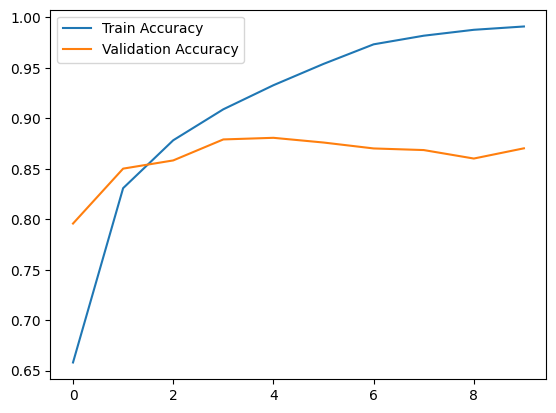

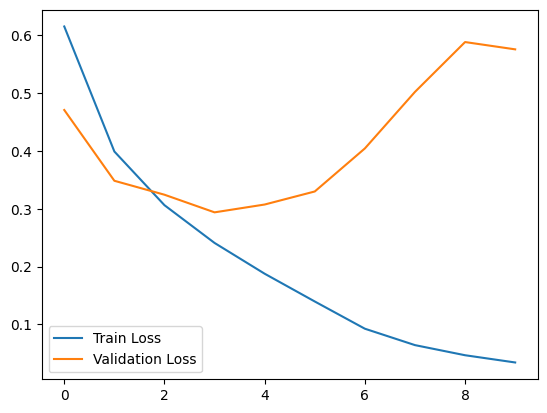

In [ ]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Sample review
new_review = ["This movie was fantastic! I really enjoyed it."]

# Preprocess the review
sequence = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(sequence, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Predict sentiment
prediction = model.predict(padded)
print(f"Sentiment Score: {prediction[0][0]}")

# Interpret the result
if prediction[0][0] >= 0.5:
    print("Positive Review")
else:
    print("Negative Review")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
Sentiment Score: 0.996032178401947
Positive Review
